<a href="https://colab.research.google.com/github/codefordurham/digital-durham/blob/master/DigitalDurhamMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pandas
!pip install folium
!pip install geopandas

In [0]:
import pandas as pd
import geopandas as gpd
import numpy
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt
!pip install descartes
!pip install plotly
# !pip install geoplot
# import geoplot.crs as gcrs

In [0]:
internetLocations = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQj0fn_AhUXrSa41nxhYoSmt8g6Aa_56P-D7OSvMrMkpUseH09a_i1nHva4KByl47sI8H4r31-DMbRY/pub?gid=0&single=true&output=csv")
internetLocations.tail()

,Location Type,Location Name,Location Address,City,State,Zip,LocationConcat,lng,lat,Open
50,Restaurant,Panera,737 9th St,Durham,NC,27705,"737 9th St, Durham, NC 27705",-78.922429,36.009617,NaN
51,Restaurant,Panera,3800 N Roxboro St,Durham,NC,27704,"3800 N Roxboro St, Durham, NC 27704",-78.898950,36.040966,NaN
52,Restaurant,Panera,3603 Witherspoon Blvd,Durham,NC,27707,"3603 Witherspoon Blvd, Durham, NC 27707",-78.989298,35.950312,NaN
53,Restaurant,Panera,6702 Fayetteville Rd Suite 1680,Durham,NC,27713,"6702 Fayetteville Rd Suite 1680, Durham, NC 27713",-78.940009,35.900943,NaN
54,Restaurant,Panera,5611 S Miami Blvd,Durham,NC,27703,"5611 S Miami Blvd, Durham, NC 27703",-78.806703,35.960737,NaN


In [0]:
def make_point(row):
    return Point(row.lng, row.lat)

def make_marker(row):
  return Markers(row.Label)
  
pointsLib = internetLocations.apply(make_point, axis=1)
libraryLocations = gpd.GeoDataFrame(internetLocations[internetLocations['Location Type'] == "Library"], geometry=pointsLib)
libraryLocations.crs = {'init': 'epsg:4326'}

pointsRest = internetLocations.apply(make_point, axis=1)
restaurantLocations = gpd.GeoDataFrame(internetLocations[internetLocations['Location Type'] == "Restaurant"], geometry=pointsRest)
restaurantLocations.crs = {'init': 'epsg:4326'}

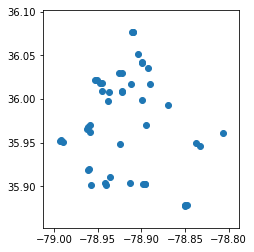

In [107]:
restaurantLocations.plot()

In [0]:
dcb = gpd.read_file("https://opendata.arcgis.com/datasets/01b3cb54b5a64105a742d5c5b4217599_0.geojson")
blocks = gpd.read_file("https://github.com/codefordurham/digital-durham/raw/master/DurhamCountyCensusBlocks.geojson")

In [109]:

bounds = folium.GeoJson(dcb).get_bounds()
center = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2]
m = folium.Map(
  location=center,
  zoom_start=10,
   tiles=None
)

folium.TileLayer (
  tiles='cartodbpositron',
  show=True,
  control=False
).add_to(m)

# Add county boundary
folium.Choropleth(
    geo_data=dcb['geometry'],
    name='County Boundary',
    fill_color='#00000000',
    fill_opacity=0.0,
    line_opacity=0.8,
    line_color='gray',
    line_weight=4
).add_to(m)

# Add census block lines
folium.Choropleth(
    geo_data=blocks['geometry'],
    name='Census Blocks',
    fill_color='#00000000',
    fill_opacity=0.0,
    line_opacity=0.1,
    line_color='gray',
    line_weight=2
).add_to(m)

In [0]:
blocks = gpd.read_file("https://github.com/codefordurham/digital-durham/raw/master/DurhamCountyCensusBlocks.geojson")
# blocks.plot()

internetBlocks = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQbfMNGA2NObb9dxhCjWMqf-tFwfx2QM-2jhsTcCcLQcwnHYzmUxzOPtPtJ4H-mdn3wedMCXNl8bwXQ/pub?output=csv")
# internetBlocks.head()

accessPercent = pd.DataFrame(internetBlocks)
# accessPercent.head()

In [111]:
# Add internet access percentage tint for each census block
folium.Choropleth(
    geo_data=blocks,
    data=accessPercent,
    columns=['AFFGEOID', 'PercWithoutInternet'],
    name="Census Blocks",
    key_on='feature.properties.AFFGEOID',
    fill_color='YlGnBu',
    fill_opacity=0.3,
    line_color='black',
    line_opacity=0.4,
    popup=accessPercent['PercWithoutInternet'],
    legend_name='Percentage of Households without Internet',
    weight=1
).add_to(m)

In [112]:
libraries = folium.FeatureGroup(name='Libraries', control=True)
restaurants = folium.FeatureGroup(name='Restaurants with Wi-fi Access', control=True)

# Red markers are library locations
for index, row in libraryLocations.iterrows():
  folium.CircleMarker([row['lat'], row['lng']], radius=1.5, popup = "<strong>" + row['Location Name']  + "</strong><br/>" + row['LocationConcat'], layer='Libraries', color='red', fill_color='red').add_to(libraries)

# Blue markers are restaurant locations
for index, row in restaurantLocations.iterrows():
  folium.CircleMarker([row['lat'], row['lng']], radius=1.5, layer='Restaurants with Wi-fi Access',color='#1324bc', fill_color='#1324bc', popup = "<strong>" + row['Location Name']  + "</strong><br/>" + row['LocationConcat']).add_to(restaurants)

  
libraries.add_to(m)
restaurants.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

In [113]:
m